In [19]:
import netCDF4 as nc
import os
import numpy as np
import pandas as pd

## Название датасета: Sea level daily gridded data from satellite observations for the global ocean from 1993 to present
### *[Источник](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-level-global?tab=overview)*

## Смотрим на содержание файла netCDF: необходимая величина - sea_surface_height_above_geoid - 'adt'

In [49]:
ds_folder_name='./dataset2002_reanalysis'
my_example_nc_file = os.path.join(ds_folder_name, os.listdir(ds_folder_name)[0])
ds = nc.Dataset(my_example_nc_file)
#for var in ds.variables.values():
    #print(var)
print(ds['adt'])

<class 'netCDF4._netCDF4.Variable'>
int32 adt(time, latitude, longitude)
    _FillValue: -2147483647
    comment: The absolute dynamic topography is the sea surface height above geoid; the adt is obtained as follows: adt=sla+mdt where mdt is the mean dynamic topography; see the product user manual for details
    coordinates: longitude latitude
    grid_mapping: crs
    long_name: Absolute dynamic topography
    scale_factor: 0.0001
    standard_name: sea_surface_height_above_geoid
    units: m
unlimited dimensions: 
current shape = (1, 720, 1440)
filling on


## Функция для поиска индекса ближайшей ячейки по координатам (тест)

In [18]:
def geo_idx(dd, dd_array):
    geo_idx = (np.abs(dd_array - dd)).argmin()
    return geo_idx

in_lat = 77.627
in_lon = 19.877 

lats = ds.variables['latitude'][:]
lons = ds.variables['longitude'][:]

lat_idx = geo_idx(in_lat, lats)
lon_idx = geo_idx(in_lon, lons)

print(lat_idx)
print(lon_idx)

670
79


## Запускаем в цикле, формируем временной ряд

In [44]:
coordinates_from_map={'lat':[75.295924, 77.325956],
                      'lon':[18.454331, 29.460769]}

dates_list=[]
names_dict={}

for i in range (len(coordinates_from_map['lat'])):
    name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
    names_dict[name]=[]
#print(names_dict)

for file in os.listdir(ds_folder_name):
    #print(file)        
    try:
        ds = nc.Dataset(os.path.join(ds_folder_name, file))
    except Exception as e:
        print(e)
        pass
    date=file.split('_')[-2]
    dates_list.append(date)
        
    for i in range (len(coordinates_from_map['lat'])):        
        
        sea_level=np.array(ds['adt'][:, :, :])[0]

        in_lat = coordinates_from_map['lat'][i]
        in_lon = coordinates_from_map['lon'][i]

        lats = ds.variables['latitude'][:]
        lons = ds.variables['longitude'][:]

        lat_idx = geo_idx(in_lat, lats)
        lon_idx = geo_idx(in_lon, lons)

        value=sea_level[lat_idx, lon_idx]
        name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
        names_dict[name].append(value)
names_dict['dates']=dates_list

### Сортировка и запись набора данных в csv

In [45]:
pd_df = pd.DataFrame(names_dict, columns = list(names_dict.keys()))
pd_df['dates'] =  pd.to_datetime(pd_df['dates'], format='%Y%m%d')
pd_df=pd_df.sort_values(by=['dates'])
pd_df.to_csv('./2002_spitz_reanalysis.csv', sep=';')
pd_df

,75.295924_18.454331,77.325956_29.460769,dates
0,-0.3090,-0.2800,2002-01-01
1,-0.3088,-0.2786,2002-01-02
2,-0.3046,-0.2763,2002-01-03
3,-0.3042,-0.2738,2002-01-04
4,-0.3003,-0.2711,2002-01-05
...,...,...,...
360,-0.2240,-0.2017,2002-12-27
361,-0.2255,-0.2027,2002-12-28
362,-0.2264,-0.2004,2002-12-29
363,-0.2302,-0.1945,2002-12-30


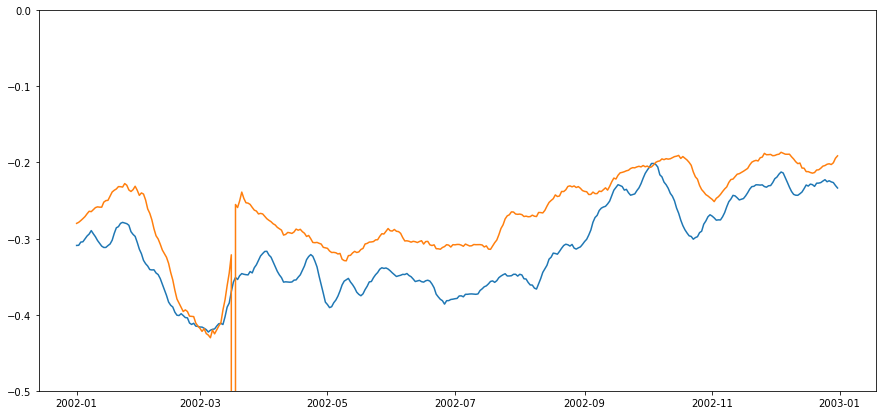

In [46]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

for key in list(names_dict.keys()):
    if key!='dates':
        plt.plot(pd_df['dates'], pd_df[key])
plt.ylim(-0.5, 0)
plt.show()